#### Imports

In [1]:
from influxdb import DataFrameClient
import pandas as pd
import seaborn as sns

import pandas_bokeh
pandas_bokeh.output_notebook()

Loading BokehJS ...

Verbindung zur Datenbank

In [2]:
client = DataFrameClient(host='css20.dmz.teco.edu', port=443, ssl=True, verify_ssl=True)#, username='fall', password='fall', database='fall')
client.get_list_database()

[{'name': '_internal'},
 {'name': 'browser'},
 {'name': 'browser_css'},
 {'name': 'browser_fall'},
 {'name': 'fall'},
 {'name': 'browser2'},
 {'name': 'test'},
 {'name': 'pyexample'},
 {'name': 'motion_data'},
 {'name': 'context_data'}]

## Daten einlesen

In [3]:
client.switch_database('fall')
df_dict = client.query("""select * FROM devicemotion""")

In [4]:
df_dict.keys()

dict_keys(['devicemotion'])

Devicemotion Messungen

In [5]:
df = df_dict.get('devicemotion')
df = df[['acceleration.x', 'acceleration.y', 'acceleration.z',
       'accelerationIncludingGravity.x', 'accelerationIncludingGravity.y',
       'accelerationIncludingGravity.z', 'label',
       'rotationRate.alpha', 'rotationRate.beta', 'rotationRate.gamma',
       'subject']]
#df = df[df['label'] != 'testing']
df.head()

,acceleration.x,acceleration.y,acceleration.z,accelerationIncludingGravity.x,accelerationIncludingGravity.y,accelerationIncludingGravity.z,label,rotationRate.alpha,rotationRate.beta,rotationRate.gamma,subject
2020-10-03 10:45:21.020600+00:00,-0.9,-0.5,1.9,-1.2,6.2,8.5,testing,-39.3,-3.9,-15.5,1e07c
2020-10-03 10:45:21.028400+00:00,-1.3,0.4,1.3,-2.8,7.5,7.8,testing,-25.3,-10.7,-10.8,1e07c
2020-10-03 10:45:21.039300+00:00,-1.3,0.4,1.3,-2.8,7.5,7.8,testing,-25.3,-10.7,-10.8,1e07c
2020-10-03 10:45:21.055800+00:00,-1.1,0.8,0.8,-2.6,7.4,7.3,testing,-12.3,-7.6,-0.1,1e07c
2020-10-03 10:45:21.072700+00:00,-0.8,0.3,0.3,-2.3,7.1,6.9,testing,1.4,5.1,18.3,1e07c


### Visualisieren von einzelnen Aufzeichnungen
Wir können sehen, dass unsere Aufzeichnung nicht nur aus fallen besteht. Es vergeht Zeit nach dem Tätigen des Schalters. Nach dem freien Fall kommt es zum Aufschlag und damit starken ausschlägen in Hinblick auf die Beschleunigungsmessungen. Danach vergeht Zeit bis der Schalter wieder getätigt wird. Für das korrekte Training müssen wir also die Messungen am Anfang und Ende der *falling* Aktionen entfernen.

In [6]:
df[df.subject == 'long_fall'][['acceleration.x', 'acceleration.y', 'acceleration.z']].plot_bokeh(kind="line") 

Figure(id='1002', ...)

Durch ausprobieren können wir sehen, dass wir ca die letzten 70 Messungen aus dem Datensatz entfernen können, da es hier zum Aufprall kommt.

In [7]:
df[df.subject == '14ca1'][30:-70][['acceleration.x', 'acceleration.y', 'acceleration.z']].plot_bokeh(kind="line") 

Figure(id='1295', ...)

Wir entfernen also für jedes 'subject' mit Falling Aktionen die letzten 70 Messungen.

In [8]:
# Liste der Subjects die falling als Aktion hatten
subjects = list(df[df.label == 'falling']['subject'].value_counts().index)

In [9]:
df_falling = pd.DataFrame()

for subject in subjects:
    df_temp = df[df.subject == subject][30:-70]
    df_falling = df_falling.append(df_temp)

Nun fügen wir die anderen Messungen aus other hinzu.

In [10]:
df_prep = df_falling.append(df[df.label == 'other'])

## Datenvisualisierung

Um zu erkennen, ob zwischen den Klassen Unterschiede bestehen, lassen wir uns die Verteilungen der Daten über den Pairplot anzeigen.

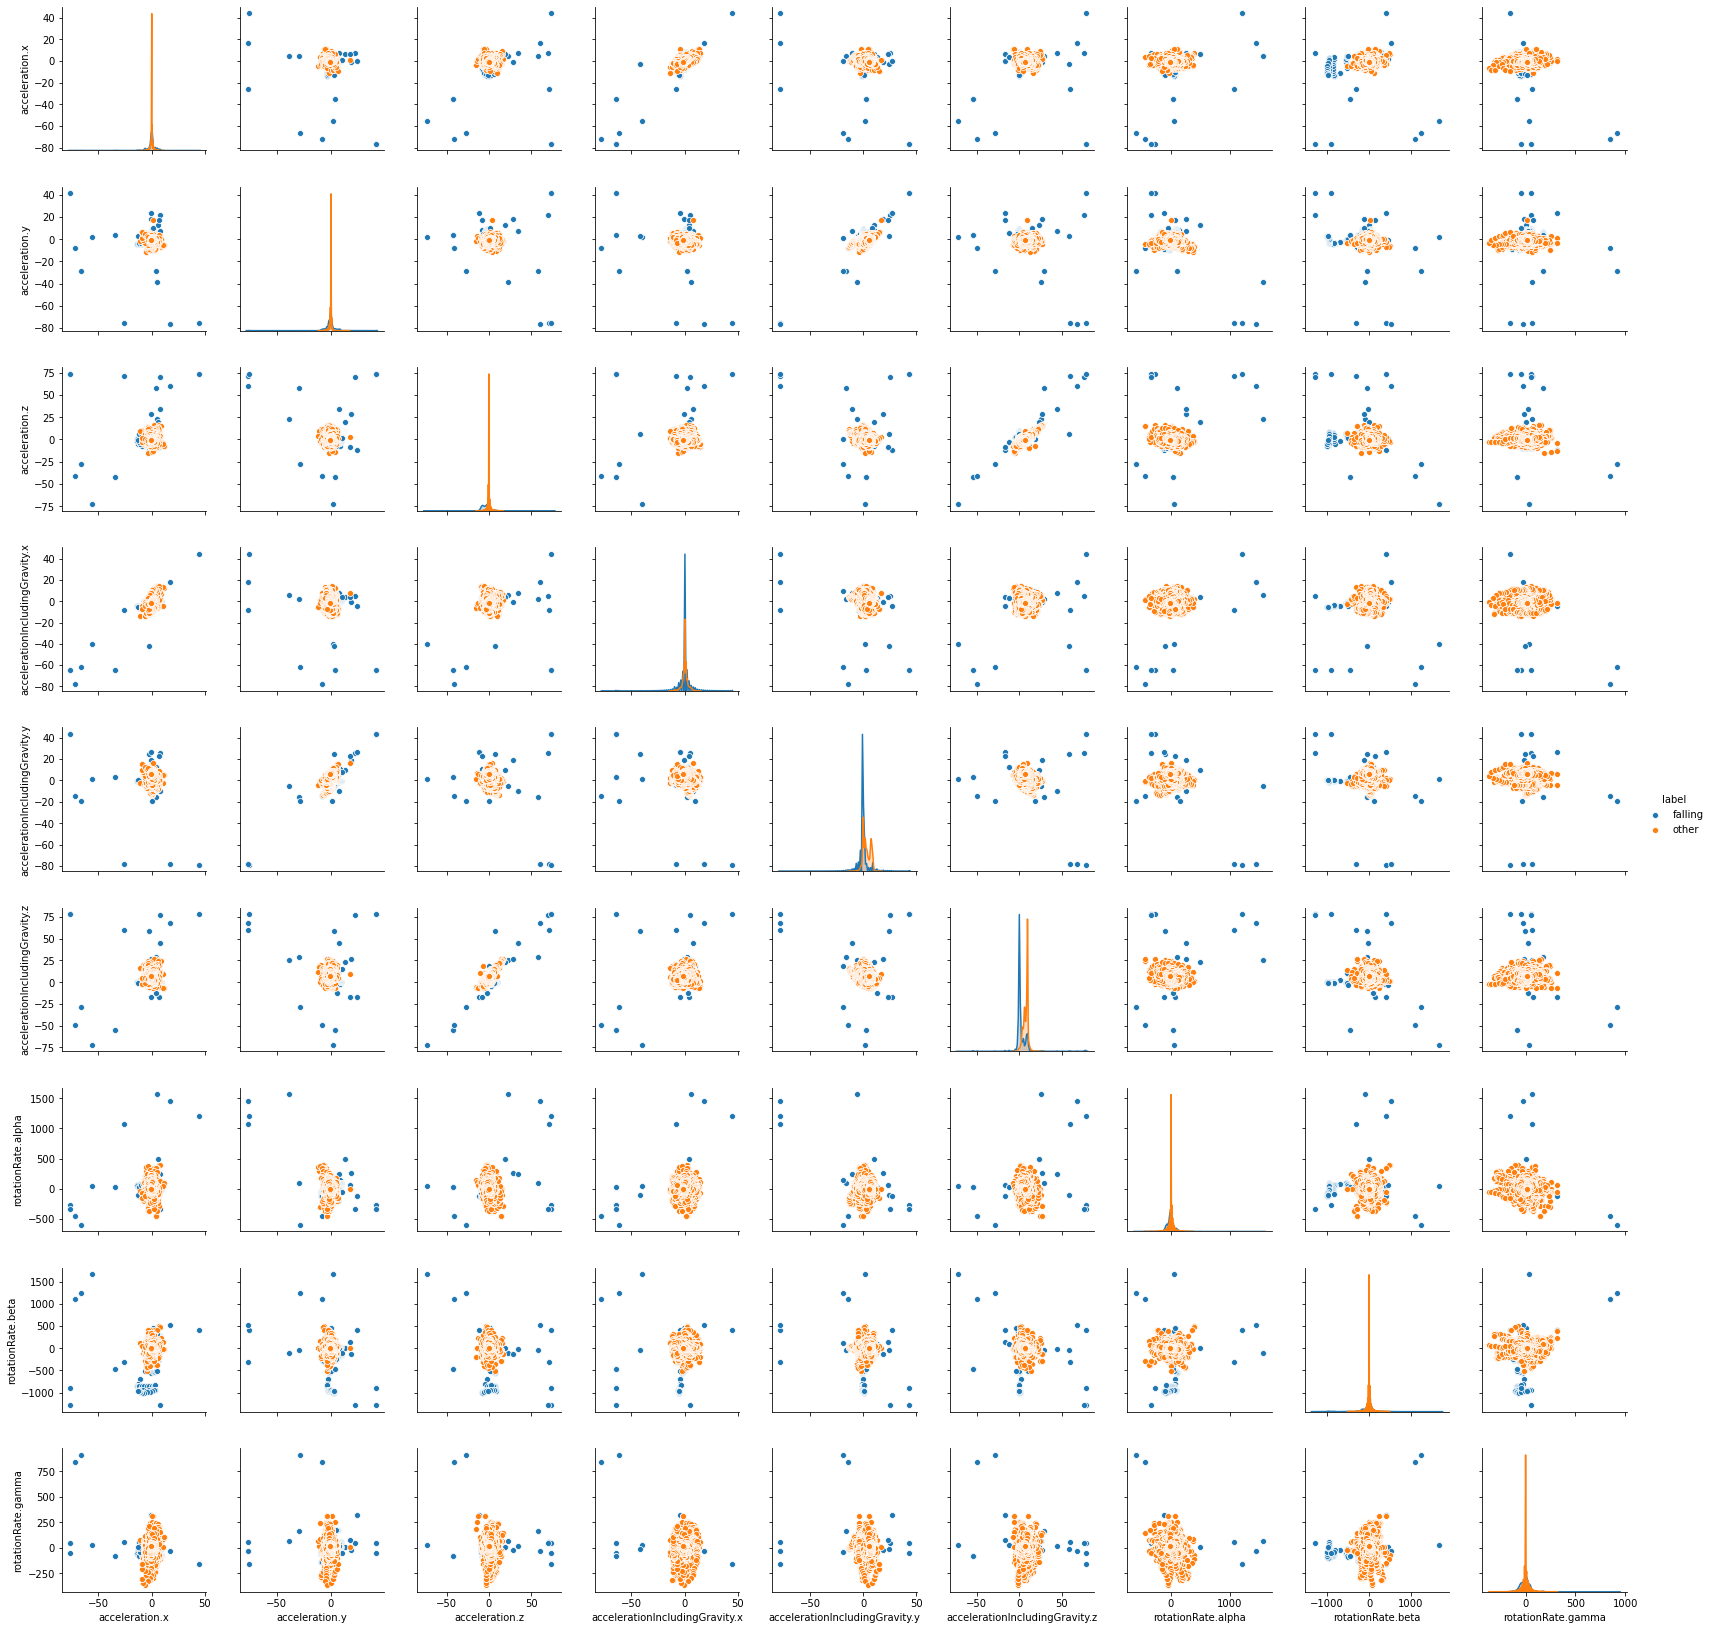

In [11]:
sns.pairplot(df_prep[['acceleration.x', 'acceleration.y', 'acceleration.z',
       'accelerationIncludingGravity.x', 'accelerationIncludingGravity.y',
       'accelerationIncludingGravity.z', 'rotationRate.alpha',
       'rotationRate.beta', 'rotationRate.gamma', 'label']], hue="label")

### PCA

In [11]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaled = scaler.fit_transform(df_prep[['acceleration.x', 'acceleration.y', 'acceleration.z',
       'accelerationIncludingGravity.x', 'accelerationIncludingGravity.y',
       'accelerationIncludingGravity.z', 'rotationRate.alpha',
       'rotationRate.beta', 'rotationRate.gamma']])

In [12]:
pca = PCA(n_components=2)
scaled = pca.fit_transform(scaled)
principalDf = pd.DataFrame(data = scaled
              , columns = ['pc1', 'pc2'])
principalDf['label'] = list(df_prep['label'])

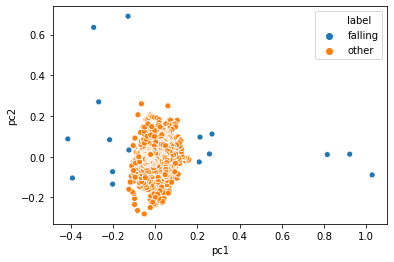

In [13]:
sns.scatterplot(data=principalDf, x="pc1", y="pc2", hue="label")

### Sliding Features

Folgende Funktion ermöglichst es uns für die Dataframes Sliding Windows zu erzeugen.

In [14]:
def add_sliding_features(df, window):
    df_output = pd.DataFrame()  # Leeres Dataframe
    subjects = df['subject'].unique()  # Maschinen die in Dataframe vorhanden sind
    cols = ['acceleration.x', 'acceleration.y', 'acceleration.z',
       'accelerationIncludingGravity.x', 'accelerationIncludingGravity.y',
       'accelerationIncludingGravity.z', 'rotationRate.alpha',
       'rotationRate.beta', 'rotationRate.gamma']  # Spaltennamen der Sensorspalten

    for subject in subjects:  # Iterieren über Maschinen
        df_temp = df[df.subject == subject].copy()
        new_cols = [s + '_rolling_' + str(window) for s in cols]
        df_temp[new_cols] = df_temp[cols].rolling(window).mean()  # Mittelwerte der letzen 'window' cycles als neue Spalten

        for col in cols:
            df_temp[col + '_rolling_' + str(window)].fillna(df[col], inplace=True)  # Null Values auffüllen
    
        df_output = df_output.append(df_temp)

    return df_output

In [15]:
df_sliding = add_sliding_features(df_prep, 5)

### Train-Test Split

Eingeteilt werden die Daten in die verschiedenen Aufzeichnungen nach Subjekt.

In [16]:
df_prep = df_sliding.copy()

In [17]:
# Liste über die Subjekte
falling_subjects = list(df_prep[df_prep.label == 'falling']['subject'].value_counts().index)
other_subjects = list(df_prep[df_prep.label == 'other']['subject'].value_counts().index)

In [18]:
# Einzelne Subjekte entweder als Test oder als Trainingsmenge
df_prep.label = df_prep.label.astype('category').cat.rename_categories({'falling': 1, 'other': 0})

df_test = df_prep[df_prep.subject.isin(falling_subjects[:10] + other_subjects[:4])]
df_train = df_prep[df_prep.subject.isin(falling_subjects[10:] + other_subjects[4:])]

In [19]:
y_train = df_train.pop('label')
y_test = df_test.pop('label')

### Random Forest Classifier

Funktion für das Trainieren und Testen des RF-Classifiers.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

def train_test_rf(df_train, y_train, df_test, y_test):
    rf = RandomForestClassifier(class_weight='balanced', random_state=1, n_estimators=100, max_depth=10, min_samples_leaf=10, bootstrap=True)
    rf.fit(df_train.drop('subject', axis=1), y_train)
    preds = rf.predict(df_test.drop('subject', axis=1))

    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d")
    return rf

#### Modell mit Sliding-Features

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, random_state=1)

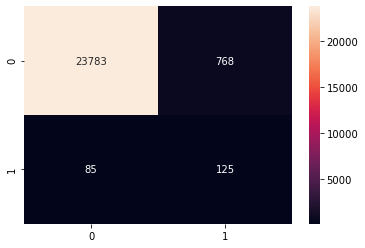

In [21]:
train_test_rf(df_train, y_train, df_test, y_test)

In [22]:
cols = ['acceleration.x', 'acceleration.y', 'acceleration.z',
       'accelerationIncludingGravity.x', 'accelerationIncludingGravity.y',
       'accelerationIncludingGravity.z', 'rotationRate.alpha',
       'rotationRate.beta', 'rotationRate.gamma', 'subject']

#### Modell ohne Sliding-Features

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, random_state=1)

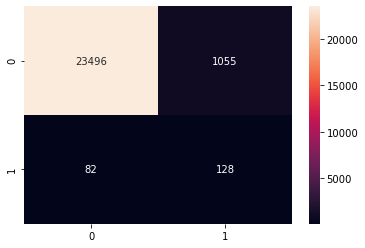

In [23]:
train_test_rf(df_train[cols], y_train, df_test[cols], y_test)

### AdaBoost

In [24]:
from sklearn.ensemble import AdaBoostClassifier
def train_test_boosting(df_train, y_train, df_test, y_test):
    boosting = AdaBoostClassifier(random_state=1)
    boosting.fit(df_train.drop('subject', axis=1), y_train)
    preds = boosting.predict(df_test.drop('subject', axis=1))

    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d")
    return boosting

#### Modell mit Sliding-Features

AdaBoostClassifier(random_state=1)

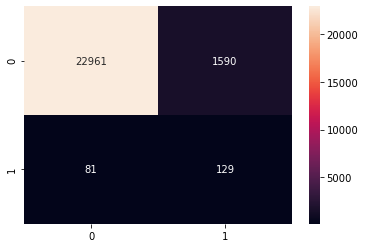

In [25]:
train_test_boosting(df_train, y_train, df_test, y_test)

#### Modell ohne Sliding-Features

AdaBoostClassifier(random_state=1)

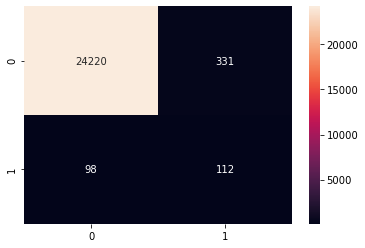

In [26]:
train_test_boosting(df_train[cols], y_train, df_test[cols], y_test)

### Hyperparameteroptimierung

Aus unseren intialen Modelle hat sich ergeben, dass der RandomForest ohne sliding_features gut performed. Da wir ohne sliding_features in unserer Webapp weniger vorzuverarbeiten haben, wählen wir also diese Variante aus und optimieren die Hyperparameter mit einer RandomizedSearch mit CV. Da wir auch keine Features verwenden, die messungen über mehrere Zeitpunkte enthalten, können wir die Vorhersagen über die Features einzeln betrachten und somit eine einfach CrossValidation verwenden.

In [27]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 5, 7, 9, 11, 12, 14, 16, 18, 20, None], 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 8, 10], 'bootstrap': [True, False]}


Verwenden einer Group CV um zeitlichen Abhängigkeiten entgegenzuwirken.

In [28]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=10)


In [29]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(n_jobs = -1)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = gkf, 
                               verbose=2, random_state=42, n_jobs = 1, scoring='precision')
# Fit the random search model
rf_random.fit(df_train.drop('subject', axis=1), y_train, groups=df_train['subject'])

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True, total=   2.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True, total=   0.2s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True, total=   0.2s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True, total=   0.2s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=7, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=15,

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_esti

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   0.2s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=30, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=3, bootstrap=False 
[CV]  n_estimators=20, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=70, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False, total=   0.1s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=8, max_features=auto, max_depth=20, bootstrap=False, total=   0.1s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, total=   0.2s
[CV] n_estimators=90, min_sam

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=True 
[CV]  n_estimators=90, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=True 
[CV]  n_estimators=40, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=2, min_samp

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=80, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=10

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=90, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=12, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=20, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=60, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_esti

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=18, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=18, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=18, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=18, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=18, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=18, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=18, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=18, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=18, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=18, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=18, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=18, bootstrap=True 
[CV]  n_estimators=60, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=14, bootstrap=False 
[CV]  n_estimators=60, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=50, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=50, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=50, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=50, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=50, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=50, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=15,

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=11, bootstrap=False 
[CV]  n_estimators=60, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False, total=   0.3s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=50, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV]  n_estimators=10, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=11, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=11, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=11, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=11, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=11, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=11, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=11, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=11, bootstrap=True 
[CV]  n_estimators=10, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True, total=   0.0s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=3, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=10,

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True, total=   0.3s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=70, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=2, bootstrap=False, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=2, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=2, bootstrap=False, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=2, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=2, bootstrap=False, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=2, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=2, bootstrap=False, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=2, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=2, bootstrap=False, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=2, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=2, bootstrap=False, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=2, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=5, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=20, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.1s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=90, min_samples_split=5

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=90, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=False 
[CV]  n_estimators=80, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=7, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=7, bootstrap=False 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=7, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=7, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=7, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=7, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=5,

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samp

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=True, total=   0.1s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10, min_

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10,

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=2, min_samp

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=100, min_samples_

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=80, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=30, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=80, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=18, bootstrap=False 
[CV]  n_estimators=100, min_

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.2s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.2s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.2s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.2s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.3s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.3s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True, total=   0.3s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=1, max_features=auto, max_depth=2, bootstrap=True 
[CV]  n_estimators=100, min_samples_

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True, total=   0.0s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True, total=   0.0s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=5, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5,

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 
[CV]

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=10, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=70, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=False, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=False, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=False, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=False, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=False, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=False, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=5, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_esti

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.3s
[CV] n_estimators=90, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=90, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=5, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True, total=   0.3s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=40, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=7, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=5, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=14, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=14, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=14, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=14, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=10, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=70, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=70, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=9, bootstrap=False 
[CV]  n_estimators=60, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=5, bootstrap=False 
[CV]  n_estimators=100, min_

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=8, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=50, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True, total=   0.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=5, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=5, min_samp

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=Fal

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=80, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=80, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=50, min_samples_

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=10, min_samples_leaf=10, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_esti

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=16, bootstrap=False 
[CV]  n_estimators=80, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=10, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=9, bootstrap=False 
[CV]  n_estimators=100, min_samples_

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=30, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=30, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=30, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=30, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=30, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.1s
[CV] n_estimators=30, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=30, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=30, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=30, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=30, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=30, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=30, min_samples_split=15, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=30, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=10, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=3, bootstrap=False 
[CV]  n_estimators=60, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=100, min_

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_features=sqrt, max_depth=2, bootstrap=False 
[CV]  n_estimators=100, min_samples_

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=90, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=12, bootstrap=False 
[CV]  n_estimators=80, min_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=7, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=7, bootstrap=False 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=7, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=7, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=7, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=7, bootstrap=False 
[CV]  n_estimators=50, min_

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=8, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=8, max_features=sqrt, max_depth=20, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=8, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=8, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=8, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=8, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=8, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=8, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=8, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=8, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=40, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=10, max_features=auto, max_depth=9, bootstrap=True 
[CV]  n_estimators=40, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=7, bootstrap=False 
[CV]  n_estimators=60, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=15, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=8

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True, total=   0.3s
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=9

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=80, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True, total=   0.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=12, bootstrap=True 
[CV]  n_estimators=10, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=None, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=15, min_samples_leaf=8, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=6

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=40, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 


[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, bootstrap=False, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=2, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=5,

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=16, bootstrap=True 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=16, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=16, bootstrap=True 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=16, bootstrap=True 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=16, bootstrap=True 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=16, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=16, bootstrap=True 
[CV]  n_estimators=30, min_samples_split=2, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=10, max_features=sqrt, max_depth=14, bootstrap=True 
[CV]  n_estimators=60, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV]  n_estimators=10, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=False, total=   0.0s
[CV] n_estimators=10, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=False, total=   0.0s
[CV] n_estimators=10, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=False, total=   0.1s
[CV] n_estimators=10, min_samples_split=15, min_samples_leaf=4, max_features=auto, max_depth=5, bootstrap=False 
[CV]  n_estimators=10, min_samples_s

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_est

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, total=   0.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, total=   0.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, total=   0.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, total=   0.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, total=   0.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, total=   0.5s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True, total=   0.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=11, bootstrap=True 
[CV]  n_estimators=100, min_samples_

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=12, bootstrap=True 
[CV]  n_estimators=60, min_samples_split=2, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.2s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True, total=   0.3s
[CV] n_estimators=80, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=14, bootstrap=True 
[CV]  n_estimators=80, min_samples_split=2, 

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.3s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False, total=   0.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=10, max_features=sqrt, max_depth=12, bootstrap=False 
[CV]  n_estimators=6

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=14, bootstrap=False 
[CV]  n_estimators=1

C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False 


C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marku\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=15, min_samples_leaf=8, max_features=auto, max_depth=16, bootstrap=False 
[CV]  n_estimators=40, min_s

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  3.3min finished


RandomizedSearchCV(cv=GroupKFold(n_splits=10),
                   estimator=RandomForestClassifier(n_jobs=-1), n_iter=100,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 3, 5, 7, 9, 11, 12, 14,
                                                      16, 18, 20, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8, 10],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, scoring='precision', verbose=2)

In [31]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=15,
                       n_estimators=90, n_jobs=-1)

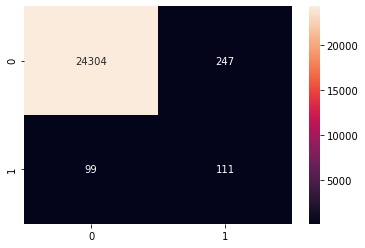

In [32]:
sns.heatmap(confusion_matrix(y_test, rf_random.best_estimator_.predict(df_test.drop('subject', axis=1))), annot=True, fmt="d")

### Visualisieren der Vorhersage

In [33]:
df_eval = df_test.copy()
df_eval['pred'] = rf_random.best_estimator_.predict(df_test.drop('subject', axis=1))
df_eval['true'] = y_test.astype(int)

In [34]:
df_eval[df_eval.subject == '128f1'][['acceleration.x', 'acceleration.y', 'acceleration.z', 'pred', 'true']].plot_bokeh(kind="line") 

Figure(id='1611', ...)

### Export des Classifiers

In [35]:
from sklearn_porter import Porter

porter = Porter(rf_random.best_estimator_, language='js')
output = porter.export(embed_data=True)

C:\Users\marku\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\marku\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.weight_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\marku\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in vers

In [36]:
output

"var RandomForestClassifier = function() {\n\n    var findMax = function(nums) {\n        var index = 0;\n        for (var i = 0; i < nums.length; i++) {\n            index = nums[i] > nums[index] ? i : index;\n        }\n        return index;\n    };\n\n    var trees = new Array();\n\n    trees.push(function(features) {\n        var classes = new Array(2);\n        \n        if (features[7] <= -155.0) {\n            if (features[5] <= 1.75) {\n                if (features[2] <= -7.599999904632568) {\n                    classes[0] = 1; \n                    classes[1] = 5; \n                } else {\n                    classes[0] = 0; \n                    classes[1] = 88; \n                }\n            } else {\n                if (features[10] <= 0.06000000424683094) {\n                    classes[0] = 33; \n                    classes[1] = 0; \n                } else {\n                    classes[0] = 3; \n                    classes[1] = 3; \n                }\n            }\n

In [37]:
with open('../RandomForestClassifier.js', 'w') as f:
    f.write(output)